# Pipeline for AGEP column

Enable auto-reloading of external modules

In [40]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import dependencies

In [57]:
from matplotlib import rcParams
from sys import getsizeof
from pprint import pprint

from utils.data_loader import *
from utils.null_handler import *
from utils.EDA_utils import *
from utils.simple_utils import *
from utils.model_tuning_utils import *
from utils.stability_analysis import *
from utils.analysis_helper import *
from config import *

import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

plt.style.use('mpl20')
matplotlib.rcParams['figure.dpi'] = 100

In [42]:
try:
    from folktables import ACSDataSource, ACSEmployment
except:
    !pip install folktables
    from folktables import ACSDataSource, ACSEmployment

## Loading ACSEmployment data

In [43]:
TARGET_COLUMN = 'AGEP'
COLUMN_TYPE = get_column_type(TARGET_COLUMN)

In [44]:
X_data_load, y_data = ACSDataLoader(task=DATASET_CONFIG['task'], state=DATASET_CONFIG['state'], year=DATASET_CONFIG['year'])

In [45]:
# If the task is ACSEmployment, we can optimize the file size
print(f'Original: {int(getsizeof(X_data_load) / 1024**2)} mb')
print(f'Optimized: {int(getsizeof(optimize_ACSEmployment(X_data_load)) / 1024**2)} mb')

X_data = optimize_ACSEmployment(X_data_load)

Original: 24 mb
Optimized: 12 mb


In [46]:
missing = ['SCHL', 'ESP', 'MIG', 'MIL', 'DREM']
X_data = initially_handle_nulls(X_data, missing)
# Rechecking if there are nulls -- if the null_handler has run correctly, there should not be
X_data.isnull().sum()

Dataset shape before handling nulls:  (196967, 16)
Impute values:  {'SCHL': 0, 'ESP': 0, 'MIG': 0, 'MIL': 0, 'DREM': 0}
Dataset shape after handling nulls:  (196967, 16)


AGEP        0
SCHL        0
MAR         0
RELP        0
DIS         0
ESP         0
CIT         0
MIG         0
MIL         0
ANC         0
NATIVITY    0
DEAR        0
DEYE        0
DREM        0
SEX         0
RAC1P       0
dtype: int64

## Tune hyper-parameters and find the best model

### The best model for a baseline dataset (no nulls)

In [47]:
ML_baseline_results_df = pd.read_csv(os.path.join('..', 'results', 'ML_baseline_results_df.csv'))
ML_baseline_results_df

,Unnamed: 0,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,0,Folktables [NY 2018],LogisticRegression,0.7998,0.7999,"{'max_iter': 100, 'penalty': 'l2', 'solver': '..."
1,1,Folktables [NY 2018],DecisionTreeClassifier,0.8229,0.8230,"{'criterion': 'entropy', 'max_depth': 10, 'max..."
2,2,Folktables [NY 2018],XGBClassifier,0.8296,0.8297,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


### Find the best model for a drop-column dataset (with nulls)

Baseline X_train shape:  (157573, 15)
Baseline X_test shape:  (39394, 15)
X_train_features.columns:  Index(['MAR_1', 'MAR_2', 'MAR_3', 'MAR_4', 'MAR_5', 'MIL_0.0', 'MIL_1.0',
       'MIL_2.0', 'MIL_3.0', 'MIL_4.0', 'ESP_0.0', 'ESP_1.0', 'ESP_2.0',
       'ESP_3.0', 'ESP_4.0', 'ESP_5.0', 'ESP_6.0', 'ESP_7.0', 'ESP_8.0',
       'MIG_0.0', 'MIG_1.0', 'MIG_2.0', 'MIG_3.0', 'DREM_0.0', 'DREM_1.0',
       'DREM_2.0', 'NATIVITY_1', 'NATIVITY_2', 'DIS_1', 'DIS_2', 'DEAR_1',
       'DEAR_2', 'DEYE_1', 'DEYE_2', 'SEX_1', 'SEX_2', 'RAC1P_1', 'RAC1P_2',
       'RAC1P_3', 'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8',
       'RAC1P_9', 'RELP_0', 'RELP_1', 'RELP_2', 'RELP_3', 'RELP_4', 'RELP_5',
       'RELP_6', 'RELP_7', 'RELP_8', 'RELP_9', 'RELP_10', 'RELP_11', 'RELP_12',
       'RELP_13', 'RELP_14', 'RELP_15', 'RELP_16', 'RELP_17', 'CIT_1', 'CIT_2',
       'CIT_3', 'CIT_4', 'CIT_5', 'ANC_1', 'ANC_2', 'ANC_3', 'ANC_4', 'SCHL'],
      dtype='object')
Tuning for LogisticRegression is finishe

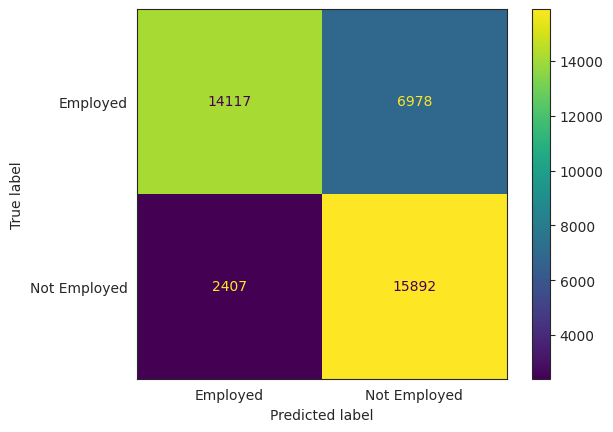

Tuning for DecisionTreeClassifier is finished
####################  Folktables [NY 2018]  ####################
Test model:  DecisionTreeClassifier
Test model parameters:
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.6}

              precision    recall  f1-score   support

           0      0.859     0.670     0.753     21095
           1      0.696     0.873     0.775     18299

    accuracy                          0.764     39394
   macro avg      0.778     0.771     0.764     39394
weighted avg      0.783     0.764     0.763     39394



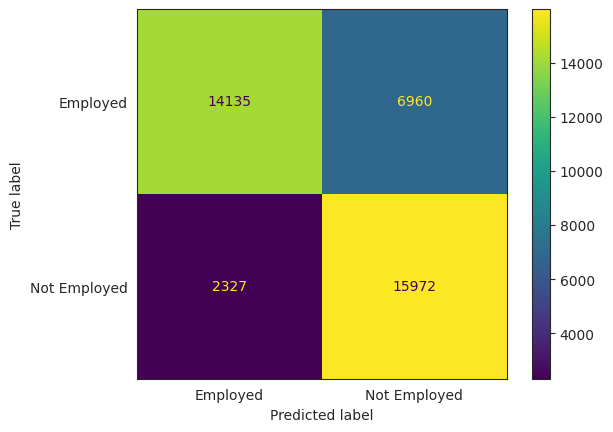

Tuning for XGBClassifier is finished
####################  Folktables [NY 2018]  ####################
Test model:  XGBClassifier
Test model parameters:
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 300,
 'objective': 'binary:logistic'}

              precision    recall  f1-score   support

           0      0.841     0.714     0.772     21095
           1      0.719     0.844     0.777     18299

    accuracy                          0.775     39394
   macro avg      0.780     0.779     0.775     39394
weighted avg      0.784     0.775     0.774     39394



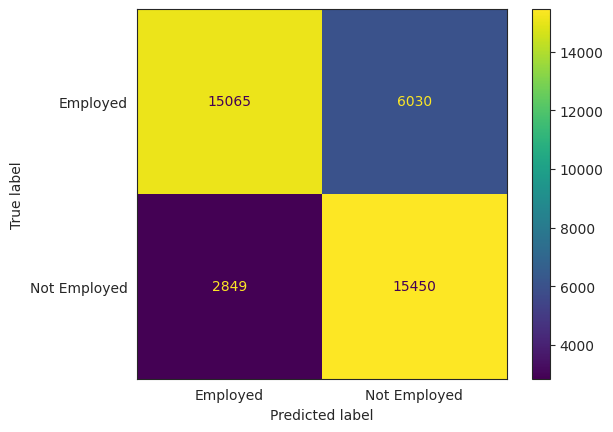

,Dataset_Name,Model_Name,F1_Score,Accuracy_Score,Model_Best_Params
0,Folktables [NY 2018],LogisticRegression,0.761281,0.761766,"{'max_iter': 50, 'penalty': 'none', 'solver': ..."
1,Folktables [NY 2018],DecisionTreeClassifier,0.763740,0.764253,"{'criterion': 'entropy', 'max_depth': 10, 'max..."
2,Folktables [NY 2018],XGBClassifier,0.774589,0.774610,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti..."


In [48]:
# Copy datasets for tuning to avoid confusion with datasets for imputations
baseline_X_data, baseline_y_data = X_data.copy(deep=True), y_data.copy(deep=True)
baseline_X_data.drop(columns=[TARGET_COLUMN], axis=1, inplace=True)
baseline_X_train_features, baseline_y_train, baseline_X_test_features, baseline_y_test = preprocess_dataset(X_data, y_data)

ML_drop_column_results_df = test_models(baseline_X_train_features, baseline_y_train, baseline_X_test_features, baseline_y_test)
ML_drop_column_results_df

In [49]:
for index, row in ML_drop_column_results_df.iterrows():
    print(f'\n\nModel name: {row["Model_Name"]}')
    pprint(row['Model_Best_Params'])



Model name: LogisticRegression
{'max_iter': 50, 'penalty': 'none', 'solver': 'saga'}


Model name: DecisionTreeClassifier
{'criterion': 'entropy', 'max_depth': 10, 'max_features': 0.6}


Model name: XGBClassifier
{'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 300,
 'objective': 'binary:logistic'}


## Simulate Null Scenarios

In [50]:
corrupted_data = simulate_scenario(X_data, SIMULATED_SCENARIOS_DICT[TARGET_COLUMN])

## Impute Nulls

Check correctness of conditional techniques

In [51]:
mapping_dict = check_conditional_techniques(corrupted_data, TARGET_COLUMN)
pprint(mapping_dict)

{'RAC1P': {'RAC1P-1': (2265, 'AGEP-60.0'),
           'RAC1P-2': (432, 'AGEP-19.0'),
           'RAC1P-3': (16, 'AGEP-17.0'),
           'RAC1P-4': (1, 'AGEP-27.0'),
           'RAC1P-5': (10, 'AGEP-52.0'),
           'RAC1P-6': (299, 'AGEP-45.0'),
           'RAC1P-7': (7, 'AGEP-29.0'),
           'RAC1P-8': (215, 'AGEP-18.0'),
           'RAC1P-9': (142, 'AGEP-1.0')},
 'SEX': {'SEX-1': (1464, 'AGEP-19.0'), 'SEX-2': (1625, 'AGEP-60.0')}}


Print plots for analysis





 ###############  Impute AGEP column with drop-column technique  ###############




 ###############  Impute AGEP column with drop-rows technique  ###############
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


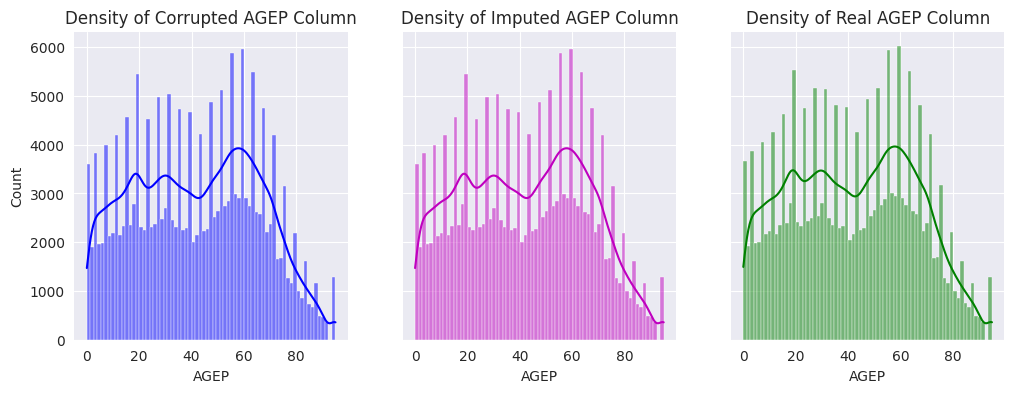





 ###############  Impute AGEP column with predict-by-sklearn technique  ###############
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


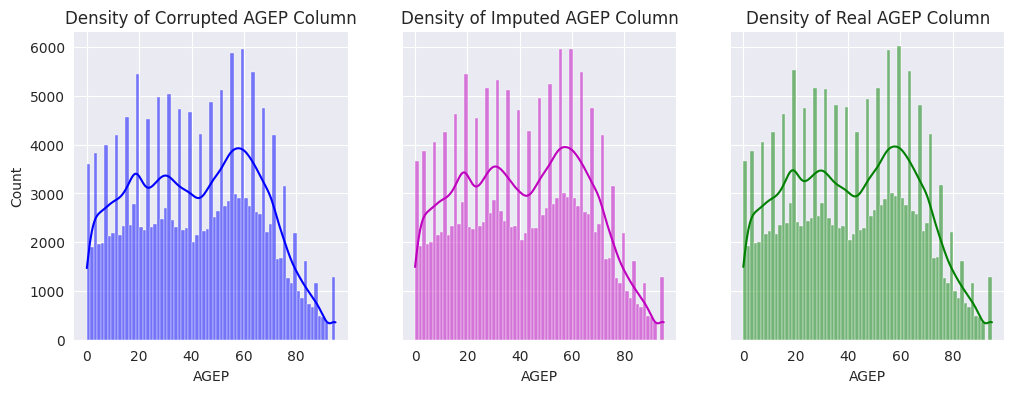





 ###############  Impute AGEP column with impute-by-mean technique  ###############
Impute values:  {'AGEP': 42.0}
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


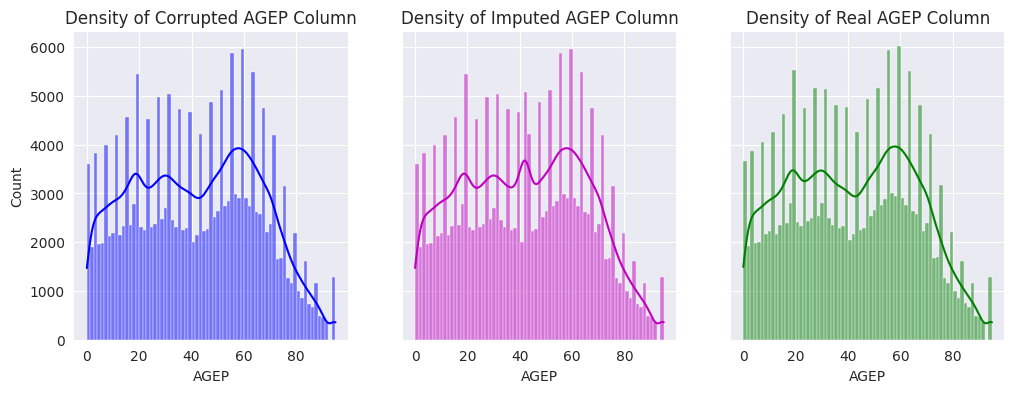





 ###############  Impute AGEP column with impute-by-mean-trimmed technique  ###############
Impute values:  {'AGEP': 42.0}
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


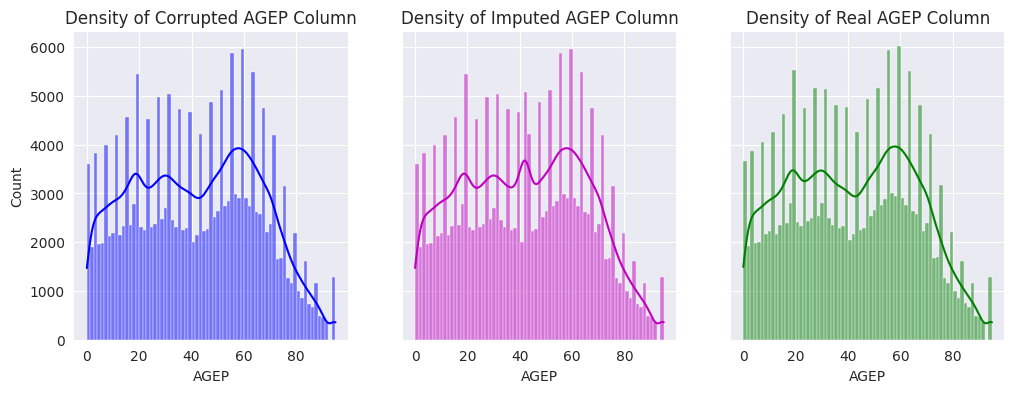





 ###############  Impute AGEP column with impute-by-mean-conditional technique  ###############
Impute AGEP with value 41.0, where SEX == 1
Impute AGEP with value 43.0, where SEX == 2
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


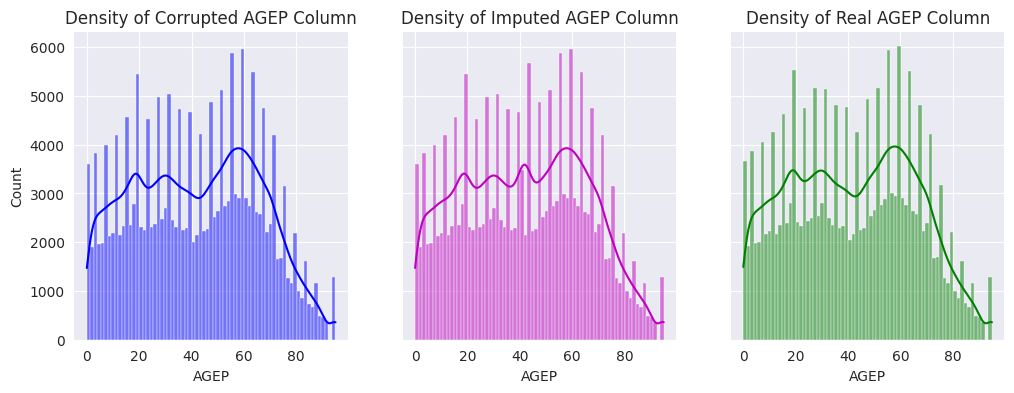

Impute AGEP with value 44.0, where RAC1P == 1
Impute AGEP with value 40.0, where RAC1P == 2
Impute AGEP with value 34.0, where RAC1P == 8
Impute AGEP with value 39.0, where RAC1P == 6
Impute AGEP with value 29.0, where RAC1P == 9
Impute AGEP with value 34.0, where RAC1P == 7
Impute AGEP with value 38.0, where RAC1P == 3
Impute AGEP with value 37.0, where RAC1P == 5
Impute AGEP with value 44.0, where RAC1P == 4
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


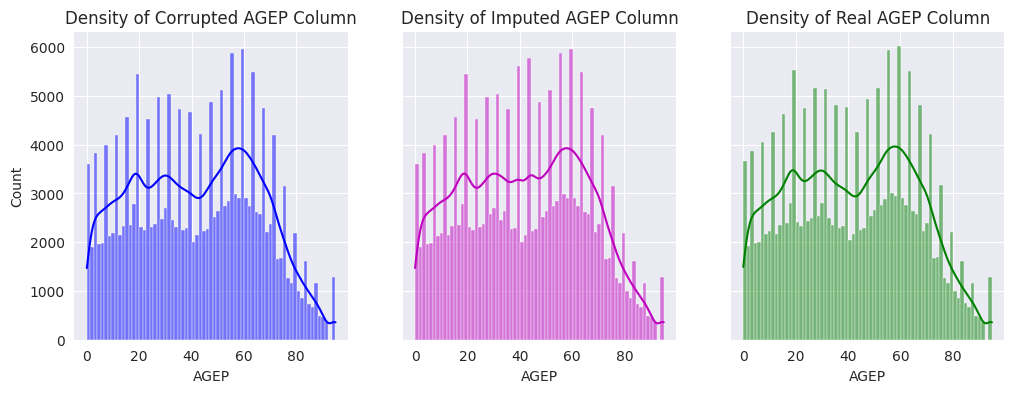





 ###############  Impute AGEP column with impute-by-median technique  ###############
Impute values:  {'AGEP': 42.0}
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


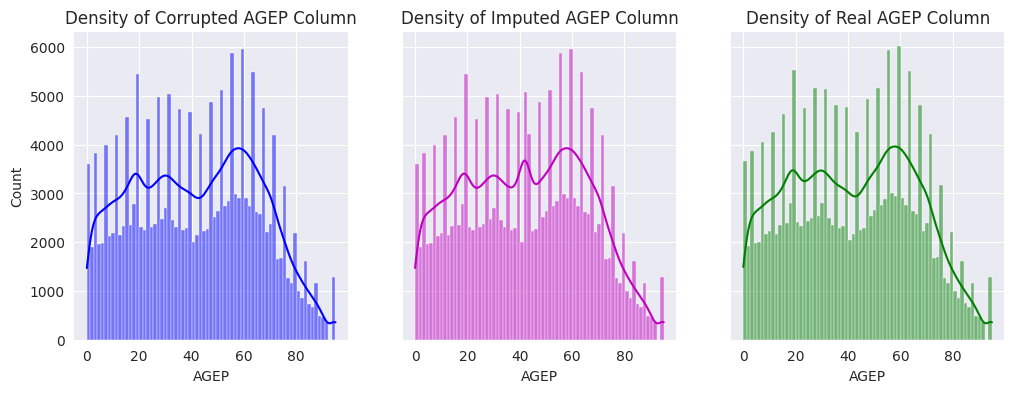





 ###############  Impute AGEP column with impute-by-median-trimmed technique  ###############
Impute values:  {'AGEP': 42.0}
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


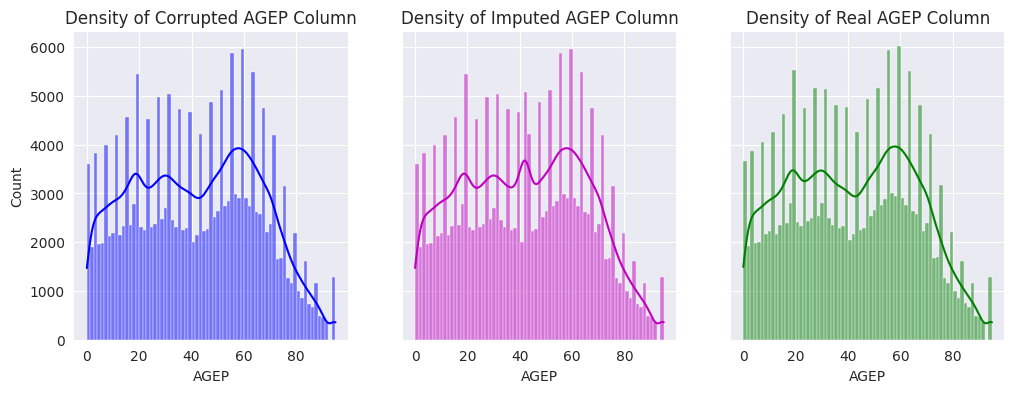





 ###############  Impute AGEP column with impute-by-median-conditional technique  ###############
Impute AGEP with value 41.0, where SEX == 1
Impute AGEP with value 44.0, where SEX == 2
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


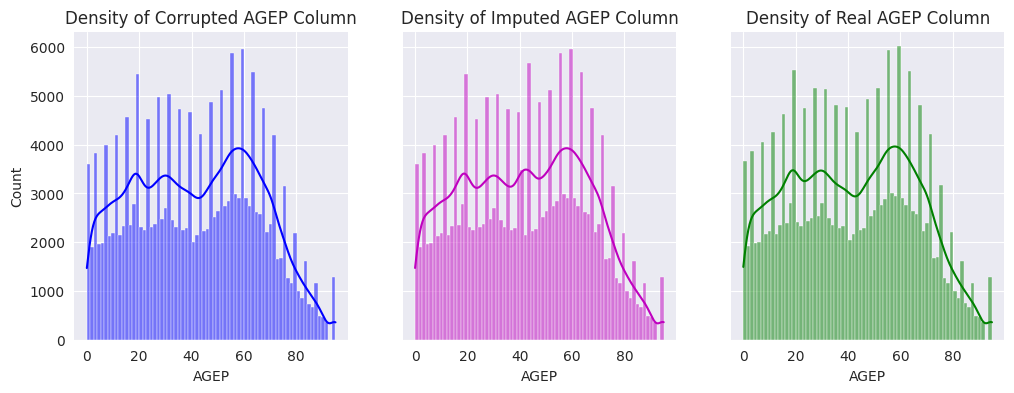

Impute AGEP with value 46.0, where RAC1P == 1
Impute AGEP with value 39.0, where RAC1P == 2
Impute AGEP with value 32.0, where RAC1P == 8
Impute AGEP with value 38.0, where RAC1P == 6
Impute AGEP with value 24.0, where RAC1P == 9
Impute AGEP with value 30.0, where RAC1P == 7
Impute AGEP with value 39.0, where RAC1P == 3
Impute AGEP with value 34.0, where RAC1P == 5
Impute AGEP with value 49.0, where RAC1P == 4
Number of nulls in AGEP column in the corrupted dataframe:  2937
Number of nulls in AGEP column in the imputed dataframe:  0


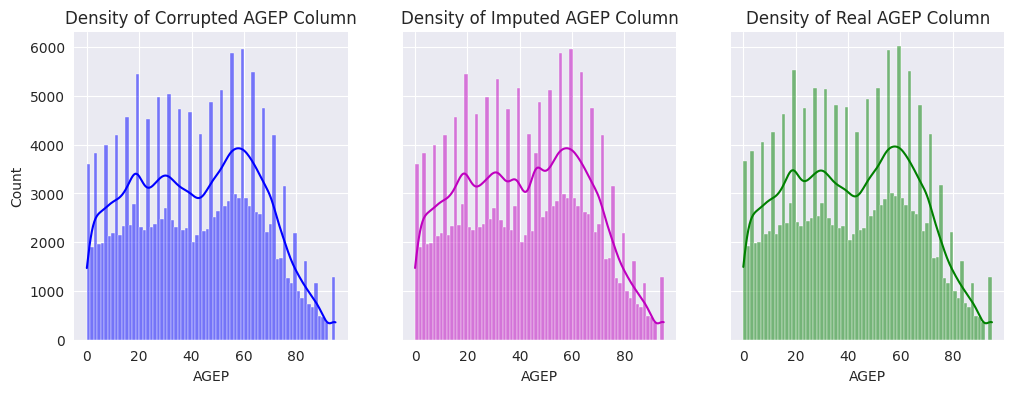

In [52]:
imputed_data_dict = impute_df_with_all_techniques(X_data, corrupted_data, TARGET_COLUMN, COLUMN_TYPE)

## Creating train-validation-test splits for imputed datasets

In [63]:
imputation_technique = 'impute-by-mean'
X_imputed = imputed_data_dict[imputation_technique]
# Also dropping rows from the label
y_data_imputed = y_data.copy(deep=True)[X_imputed.index]

X_train_imputed_, y_train_imputed_, X_test_imputed, y_test_imputed = preprocess_dataset(X_imputed, y_data_imputed)
# TODO: why do we need X_val_imputed for uncertainty analysis?
X_train_imputed, X_val_imputed, y_train_imputed, y_val_imputed = train_test_split(X_train_imputed_, y_train_imputed_, test_size=0.25, random_state=SEED)
print('X_train_imputed.shape: ', X_train_imputed.shape)
print('X_val_imputed.shape: ', X_val_imputed.shape)
print('X_test_imputed.shape: ', X_test_imputed.shape)

X_train_features shape:  (157573, 74)
X_test_features shape:  (39394, 74)
X_train_features.columns:  Index(['MAR_1', 'MAR_2', 'MAR_3', 'MAR_4', 'MAR_5', 'MIL_0.0', 'MIL_1.0',
       'MIL_2.0', 'MIL_3.0', 'MIL_4.0', 'ESP_0.0', 'ESP_1.0', 'ESP_2.0',
       'ESP_3.0', 'ESP_4.0', 'ESP_5.0', 'ESP_6.0', 'ESP_7.0', 'ESP_8.0',
       'MIG_0.0', 'MIG_1.0', 'MIG_2.0', 'MIG_3.0', 'DREM_0.0', 'DREM_1.0',
       'DREM_2.0', 'NATIVITY_1', 'NATIVITY_2', 'DIS_1', 'DIS_2', 'DEAR_1',
       'DEAR_2', 'DEYE_1', 'DEYE_2', 'SEX_1', 'SEX_2', 'RAC1P_1', 'RAC1P_2',
       'RAC1P_3', 'RAC1P_4', 'RAC1P_5', 'RAC1P_6', 'RAC1P_7', 'RAC1P_8',
       'RAC1P_9', 'RELP_0', 'RELP_1', 'RELP_2', 'RELP_3', 'RELP_4', 'RELP_5',
       'RELP_6', 'RELP_7', 'RELP_8', 'RELP_9', 'RELP_10', 'RELP_11', 'RELP_12',
       'RELP_13', 'RELP_14', 'RELP_15', 'RELP_16', 'RELP_17', 'CIT_1', 'CIT_2',
       'CIT_3', 'CIT_4', 'CIT_5', 'ANC_1', 'ANC_2', 'ANC_3', 'ANC_4', 'SCHL',
       'AGEP'],
      dtype='object')
X_train_imputed.shape:  (

## Quantifying uncertainty using posterior predictive distribution

In [ ]:
decision_tree_model = DecisionTreeClassifier(criterion='entropy', max_depth=10, max_features=0.6)
n_estimators = 50
boostrap_size = int(0.5 * X_train_imputed.shape[0])

___, uq_results = UQ_by_boostrap(X_train_imputed, y_train_imputed, X_test_imputed, y_test_imputed,
                                 decision_tree_model, n_estimators,
                                 boostrap_size, with_replacement=True, verbose=True)

In [ ]:
y_preds, results, means, stds, iqr, accuracy = count_prediction_stats(y_test_imputed, uq_results)
per_sample_accuracy, label_stability = get_per_sample_accuracy(y_test_imputed, results)

In [ ]:
plot_generic(means, stds, "Mean of probability", "Standard deviation", "Probability mean vs Standard deviation")

In [ ]:
plot_generic(stds, label_stability, "Standard deviation", "Label stability", "Standard deviation vs Label stability")

In [ ]:
plot_generic(means, label_stability, "Mean", "Label stability", "Mean vs Label stability")

In [ ]:
plot_generic(per_sample_accuracy, stds, "Accuracy", "Standard deviation", "Accuracy vs Standard deviation")

In [ ]:
plot_generic(per_sample_accuracy, iqr, "Accuracy", "Inter quantile range", "Accuracy vs Inter quantile range")

In [ ]:
fairness_metrics = get_fairness_metrics(y_preds, X_test_imputed, y_test_imputed)
pprint(fairness_metrics)

In [ ]:
metrics_to_report = {}
metrics_to_report['Accuracy'] = accuracy
metrics_to_report['Label_stability'] = [np.mean(label_stability)]
metrics_to_report['SD'] = [np.mean(stds)]
metrics_to_report['IQR'] = [np.mean(iqr)]
metrics_to_report['SPD_Race'] = [fairness_metrics['Statistical_Parity_Difference']['Race'].loc['Statistical_Parity_Difference']]
metrics_to_report['SPD_Sex'] = [fairness_metrics['Statistical_Parity_Difference']['Sex'].loc['Statistical_Parity_Difference']]
metrics_to_report['SPD_Race_Sex'] = [fairness_metrics['Statistical_Parity_Difference']['Race_Sex'].loc['Statistical_Parity_Difference']]
metrics_to_report['EO_Race'] = [fairness_metrics['Equal_Opportunity']['Race'].loc['Equal_Opportunity']]
metrics_to_report['EO_Sex'] = [fairness_metrics['Equal_Opportunity']['Sex'].loc['Equal_Opportunity']]
metrics_to_report['EO_Race_Sex'] = [fairness_metrics['Equal_Opportunity']['Race_Sex'].loc['Equal_Opportunity']]

pd.DataFrame(metrics_to_report)

In [ ]:
import pickle

filename = f"{DATASET_CONFIG['state']}_{DATASET_CONFIG['year']}_{TARGET_COLUMN}_{imputation_technique}.pkl"
f = open(os.path.join('..', 'results', filename), "wb")
pickle.dump(metrics_to_report,f)
f.close()